In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras
from keras.models import Model, load_model
from keras.layers import Input ,BatchNormalization , Activation 
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers 
from sklearn.model_selection import train_test_split
import os
import nibabel as nib
import cv2 as cv
import matplotlib.pyplot as plt
from keras import backend as K
import glob
import skimage.io as io
import skimage.color as color
import random as r
import math
from nilearn import plotting
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/name_mapping_validation_data.csv
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/survival_evaluation.csv
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_flair.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_t2.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_t1ce.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_t1.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_Br

In [2]:
import SimpleITK as sitk
from tqdm import tqdm
import cv2
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [3]:
Flair= nib.load('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_flair.nii')
Seg= nib.load('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_seg.nii')
T1= nib.load('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_t1.nii')
T1ce= nib.load('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_t1ce.nii')
T2= nib.load('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_t2.nii')

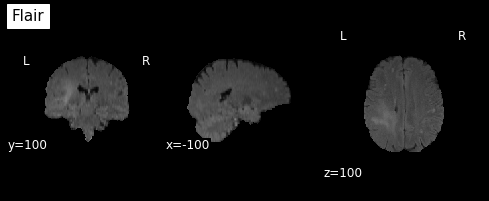

In [4]:
plotting.plot_anat(Flair,cut_coords=[-100, 100, 100],title="Flair",draw_cross =False)

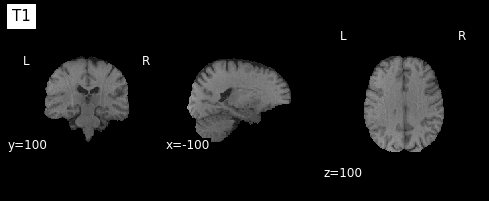

In [5]:
plotting.plot_anat(T1,cut_coords=[-100, 100, 100],title="T1",draw_cross =False)

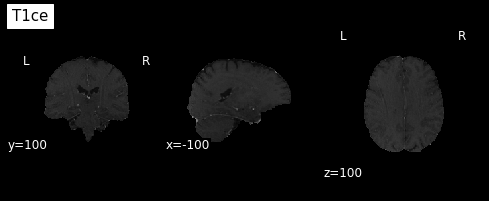

In [6]:
plotting.plot_anat(T1ce,cut_coords=[-100, 100, 100],title="T1ce",draw_cross =False)

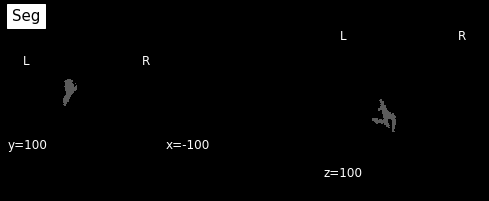

In [7]:
plotting.plot_anat(Seg,cut_coords=[-100, 100, 100],title="Seg",draw_cross =False)

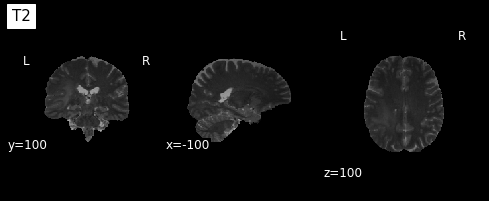

In [8]:
plotting.plot_anat(T2,cut_coords=[-100, 100, 100],title="T2",draw_cross =False)

In [9]:
import cv2 as cv
from scipy.signal.signaltools import wiener

# def binary_threshold(img):
#     img1 = img.copy().astype(np.uint8)
#     _, thres = cv.threshold(img1,0,255,cv.THRESH_OTSU)
#     return thres

# def otsu_threshold(img):
#     img1 = wiener(img, (3,3))
#     img1 = img1.astype(np.uint8)
#     _, thres = cv.threshold(img1, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
#     thres = cv.bitwise_and(thres, binary_threshold(img).astype(np.uint8))
#     return thres
def normalize(image):
    image1 = image.copy()
    min_ = np.min(image1)
    max_ = np.max(image1)
    scale = max_ - min_
    image1 = (image1 - min_) / scale
    return image1

def normalise_image(image):
    norm = np.zeros((192,192))
    norm_image = cv.normalize(image, norm, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
    norm_image = norm_image.astype(np.uint8)
    return norm_image



# def zscore_normalise(img: np.ndarray) -> np.ndarray:
#     img1 = img.copy()
#     slices = (img1 != 0)
#     img1[slices] = (img1[slices] - np.mean(img1[slices]) / np.std(img1[slices]))
#     return img1

def min_max_preprocess(image, low_perc=1, high_perc=99):
    non_zeros = image > 0
    low, high = np.percentile(image[non_zeros], [low_perc, high_perc])
    image1 = np.clip(image, low, high)
    image1 = normalise_image(image1)
    return image1

In [10]:
Path= '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
p=os.listdir(Path)
Input_Data= []
def Data_Preprocessing(modalities_dir):
    all_modalities = []    
    for modality in modalities_dir:      
        nifti_file   = nib.load(modality)
        brain_numpy  = np.asarray(nifti_file.dataobj)
        #normalise = normalise_image(brain_numpy)
        #normalised = min_max_preprocess(normalise)
        all_modalities.append(brain_numpy)
    brain_affine   = nifti_file.affine
    all_modalities = np.array(all_modalities)
    all_modalities = np.rint(all_modalities).astype(np.int16)
    all_modalities = all_modalities[:, :, :, :]
    all_modalities = np.transpose(all_modalities)
    return all_modalities
for i in p[:20]:
    brain_dir = os.path.normpath(Path+'/'+i)
    flair     = glob.glob(os.path.join(brain_dir, '*_flair*.nii'))
    t1        = glob.glob(os.path.join(brain_dir, '*_t1*.nii'))
    t1ce      = glob.glob(os.path.join(brain_dir, '*_t1ce*.nii'))
    t2        = glob.glob(os.path.join(brain_dir, '*_t2*.nii'))
    gt        = glob.glob( os.path.join(brain_dir, '*_seg*.nii'))
    modalities_dir = [flair[0], t1[0], t1ce[0], t2[0], gt[0]]
    P_Data = Data_Preprocessing(modalities_dir)
    Input_Data.append(P_Data)


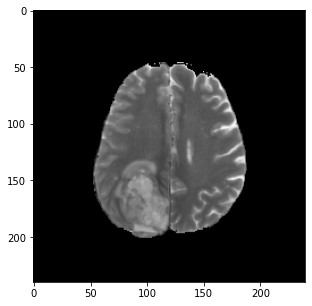

In [11]:
fig = plt.figure(figsize=(5,5))
immmg = Input_Data[1][100,:,:,3]
imgplot = plt.imshow(immmg, 'gray')
plt.show()

In [12]:
def Data_Concatenate(Input_Data):
    counter=0
    Output= []
    for i in range(5):
        print('$')
        c=0
        counter=0
        for ii in range(len(Input_Data)):
            if (counter != len(Input_Data)):
                a= Input_Data[counter][:,:,:,i]
               # print('a={}'.format(a.shape))
                b= Input_Data[counter+1][:,:,:,i]
               # print('b={}'.format(b.shape))
                if(counter==0):
                    c= np.concatenate((a, b), axis=0)
                    print('c1={}'.format(c.shape))
                    counter= counter+2
                else:
                    c1= np.concatenate((a, b), axis=0)
                    c= np.concatenate((c, c1), axis=0)
                    print('c2={}'.format(c.shape))
                    counter= counter+2
        c= c[:,:,:,np.newaxis]
        Output.append(c)
    return Output

InData= Data_Concatenate(Input_Data)

$
c1=(310, 240, 240)
c2=(620, 240, 240)
c2=(930, 240, 240)
c2=(1240, 240, 240)
c2=(1550, 240, 240)
c2=(1860, 240, 240)
c2=(2170, 240, 240)
c2=(2480, 240, 240)
c2=(2790, 240, 240)
c2=(3100, 240, 240)
$
c1=(310, 240, 240)
c2=(620, 240, 240)
c2=(930, 240, 240)
c2=(1240, 240, 240)
c2=(1550, 240, 240)
c2=(1860, 240, 240)
c2=(2170, 240, 240)
c2=(2480, 240, 240)
c2=(2790, 240, 240)
c2=(3100, 240, 240)
$
c1=(310, 240, 240)
c2=(620, 240, 240)
c2=(930, 240, 240)
c2=(1240, 240, 240)
c2=(1550, 240, 240)
c2=(1860, 240, 240)
c2=(2170, 240, 240)
c2=(2480, 240, 240)
c2=(2790, 240, 240)
c2=(3100, 240, 240)
$
c1=(310, 240, 240)
c2=(620, 240, 240)
c2=(930, 240, 240)
c2=(1240, 240, 240)
c2=(1550, 240, 240)
c2=(1860, 240, 240)
c2=(2170, 240, 240)
c2=(2480, 240, 240)
c2=(2790, 240, 240)
c2=(3100, 240, 240)
$
c1=(310, 240, 240)
c2=(620, 240, 240)
c2=(930, 240, 240)
c2=(1240, 240, 240)
c2=(1550, 240, 240)
c2=(1860, 240, 240)
c2=(2170, 240, 240)
c2=(2480, 240, 240)
c2=(2790, 240, 240)
c2=(3100, 240, 240)


In [13]:
AIO= concatenate(InData, axis=3)
AIO=np.array(AIO,dtype='float32')
TR=np.array(AIO[:,:,:,1],dtype='float32')
TRL=np.array(AIO[:,:,:,4],dtype='float32')


In [14]:

X_train , X_test, Y_train, Y_test = train_test_split(TR, TRL, test_size=0.15, random_state=32)
AIO=TRL=0


In [15]:
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer



In [16]:
input_layer = Input((240, 240, 1))
output_layer = build_model(input_layer, 16)
model = Model(input_layer, output_layer)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 240, 240, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 120, 120, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

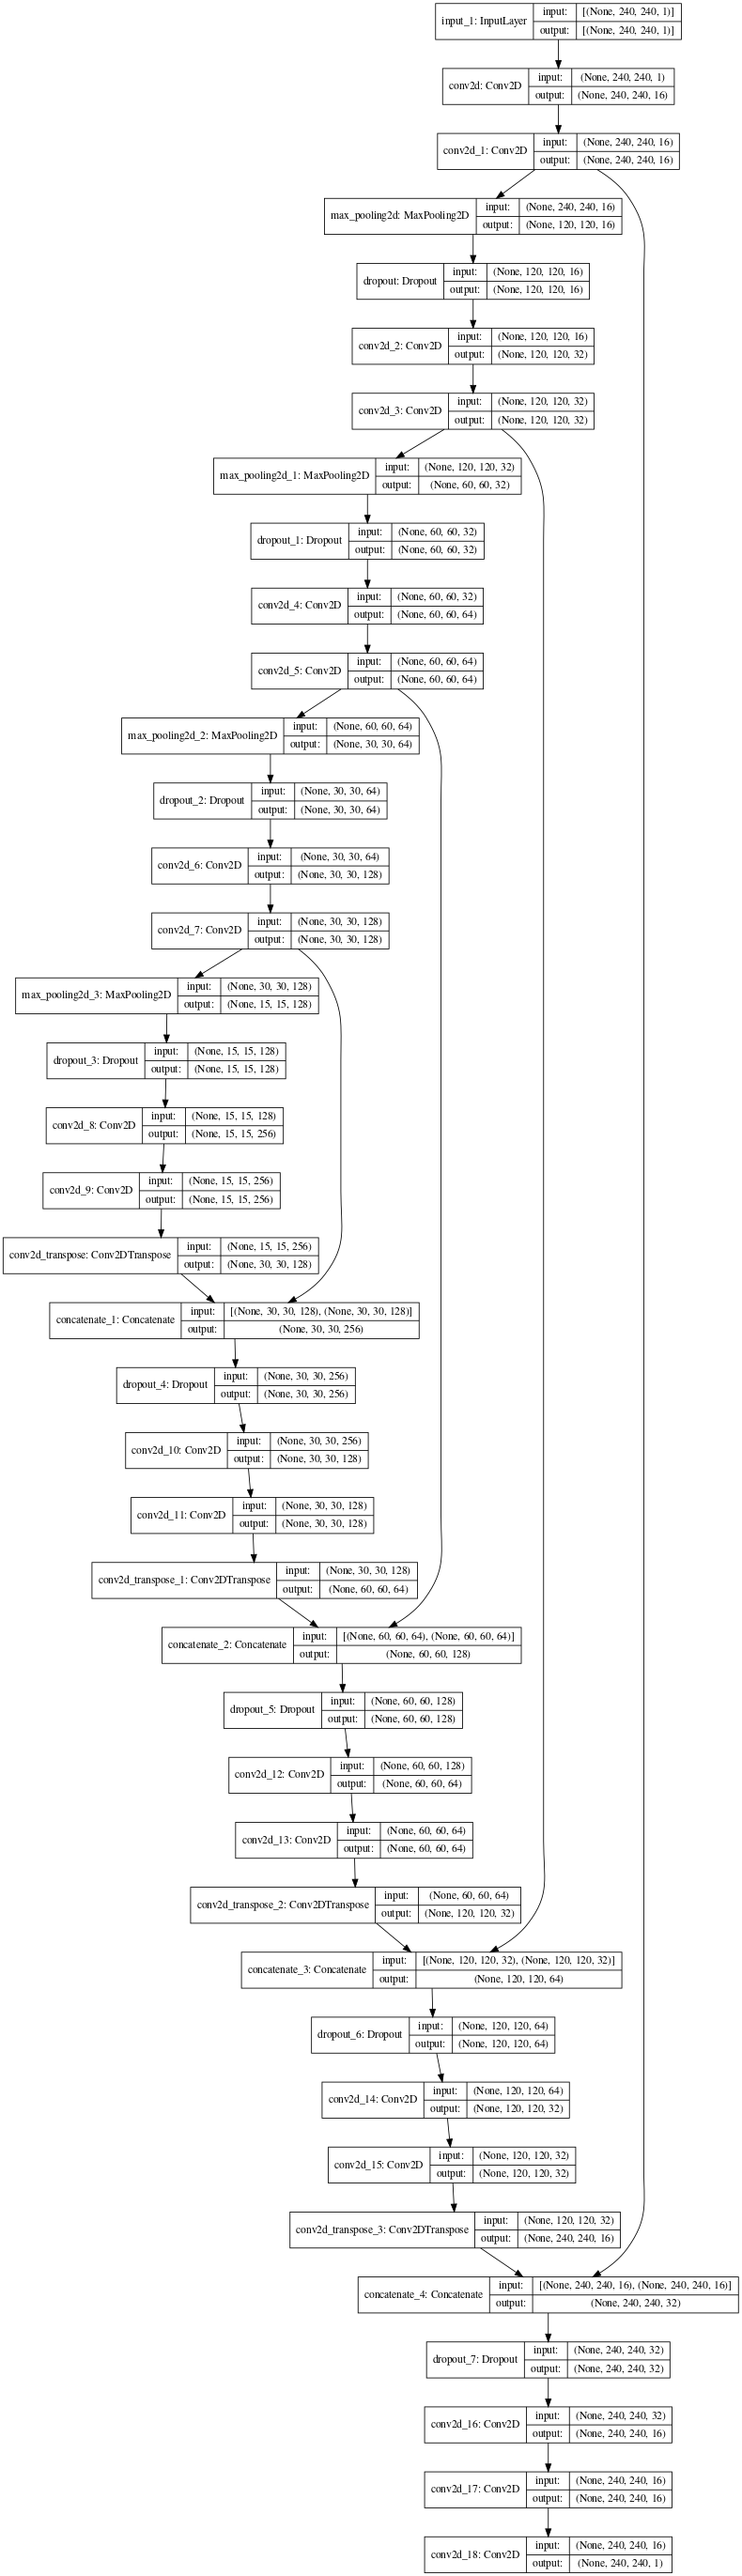

In [18]:
plot_model(model, 
           show_shapes = True, 
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 60)

In [19]:
# Computing Dice_Coefficient
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [20]:
# Compiling the model 
Adam=optimizers.Adam(lr=0.001)
model.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['accuracy',dice_coef,precision,sensitivity,specificity])

In [21]:
# Fitting the model over the data
import time
start_time = time.time()
history = model.fit(X_train,Y_train,batch_size=32,epochs=20,validation_split=0.20,verbose=1,initial_epoch=0)
end_time = time.time()
print(end_time - start_time)

Epoch 1/20
66/66 [==============================] - 18s 187ms/step - loss: 0.5210 - accuracy: 0.9662 - dice_coef: 0.0037 - precision: 0.0033 - sensitivity: 0.0341 - specificity: 0.9681 - val_loss: 0.3675 - val_accuracy: 0.9893 - val_dice_coef: 2.7833e-05 - val_precision: 0.0000e+00 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 2/20
66/66 [==============================] - 10s 157ms/step - loss: 0.3942 - accuracy: 0.9888 - dice_coef: 2.3367e-05 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 1.0000 - val_loss: 0.3675 - val_accuracy: 0.9893 - val_dice_coef: 2.7833e-05 - val_precision: 0.0000e+00 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 3/20
66/66 [==============================] - 10s 157ms/step - loss: 0.4158 - accuracy: 0.9885 - dice_coef: 2.2415e-05 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 1.0000 - val_loss: 0.3675 - val_accuracy: 0.9893 - val_dice_coef: 2.7833e-05 - val_precision: 0.0000e+00 - val_sensitivi

In [22]:
# Evaluating the model on the training and testing data 
model.evaluate(x=X_train, y=Y_train, batch_size=32 , verbose=1, sample_weight=None, steps=None)
model.evaluate(x=X_test, y=Y_test, batch_size=32, verbose=1, sample_weight=None, steps=None)

15/15 [==============================] - 1s 60ms/step - loss: 0.3536 - accuracy: 0.9902 - dice_coef: 2.8717e-05 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 1.0000


[0.3535799980163574, 0.9901830554008484, 2.871653668989893e-05, 0.0, 0.0, 1.0]

In [23]:
# Accuracy vs Epoch
def Accuracy_Graph(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    #plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
    
# Dice Similarity Coefficient vs Epoch
def Dice_coefficient_Graph(history):

    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    #plt.title('Dice_Coefficient')
    plt.ylabel('Dice_Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
# Loss vs Epoch
def Loss_Graph(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()

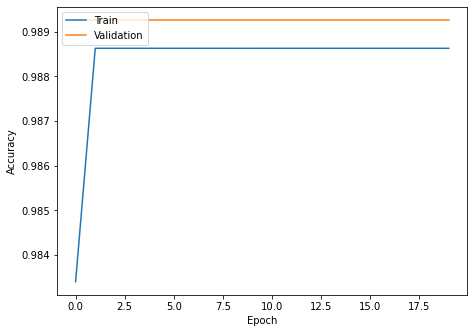

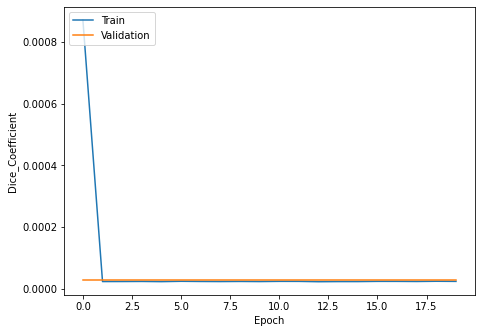

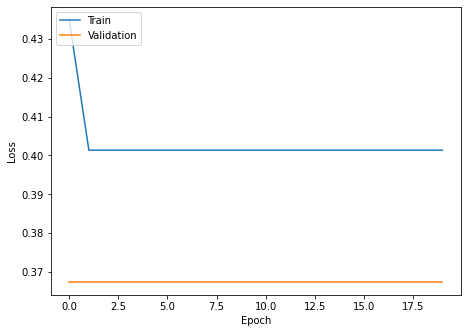

In [24]:
# Plotting the Graphs of Accuracy, Dice_coefficient, Loss at each epoch on Training and Testing data
Accuracy_Graph(history)
Dice_coefficient_Graph(history)
Loss_Graph(history)

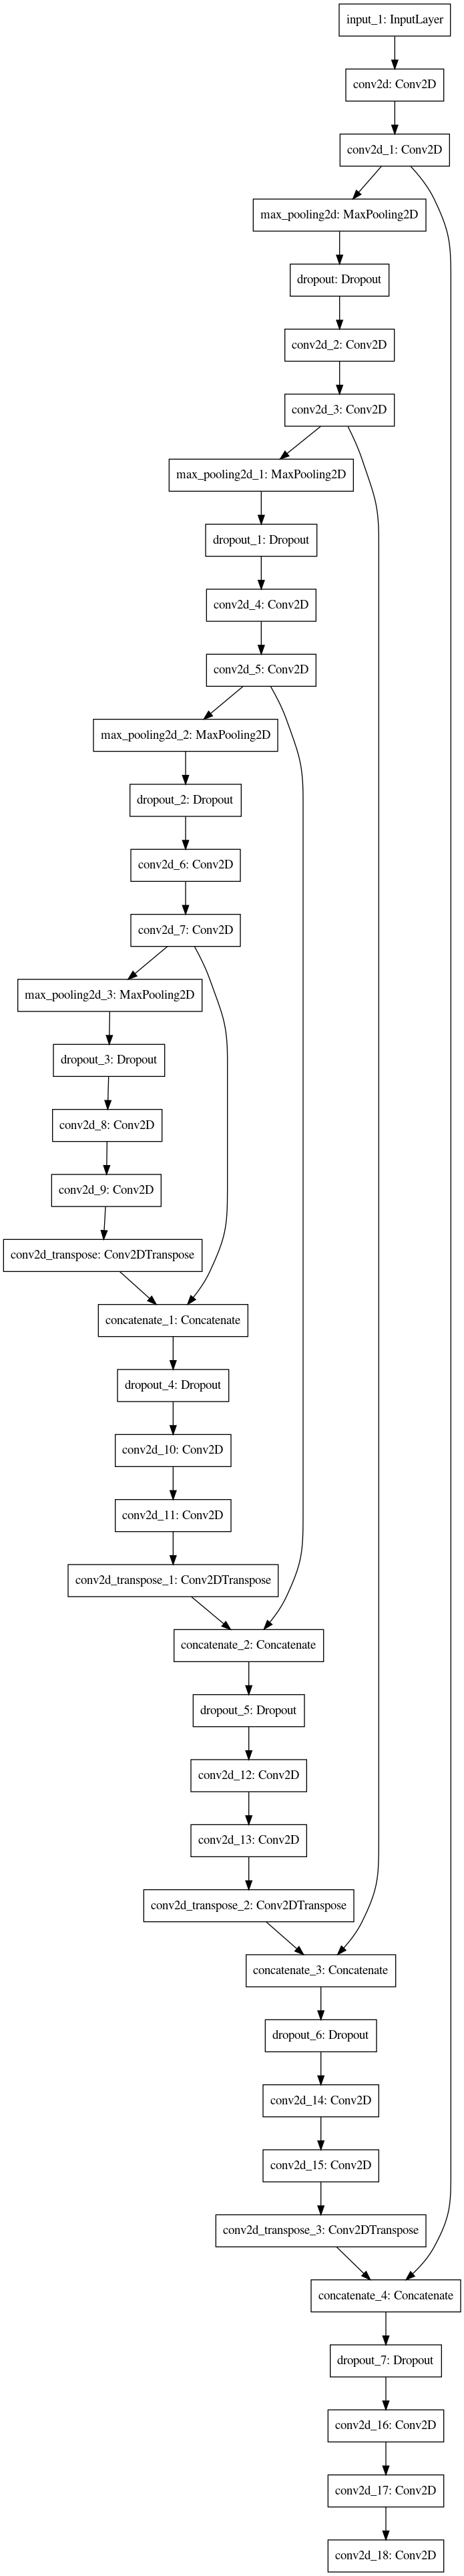

In [25]:
from keras.utils import plot_model
plot_model(model,to_file='model.png')

In [26]:
model.save('./BraTs2020.h5')
model.save_weights('BraTs2020.hdf5')

In [27]:
model.load_weights('./BraTs2020.h5')

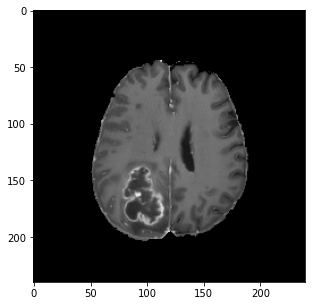

In [28]:
fig = plt.figure(figsize=(5,5))
immmg = TR[250,:,:]
imgplot = plt.imshow(immmg,'gray')
plt.show()

In [29]:
pref_Tumor = model.predict(TR)

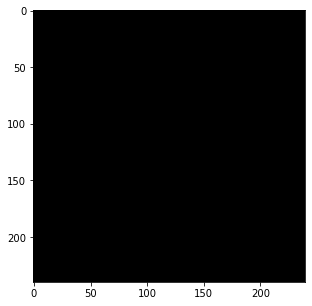

In [30]:
fig = plt.figure(figsize=(5,5))
immmg = pref_Tumor[250,:,:]
imgplot = plt.imshow(immmg,'gray')
plt.show()

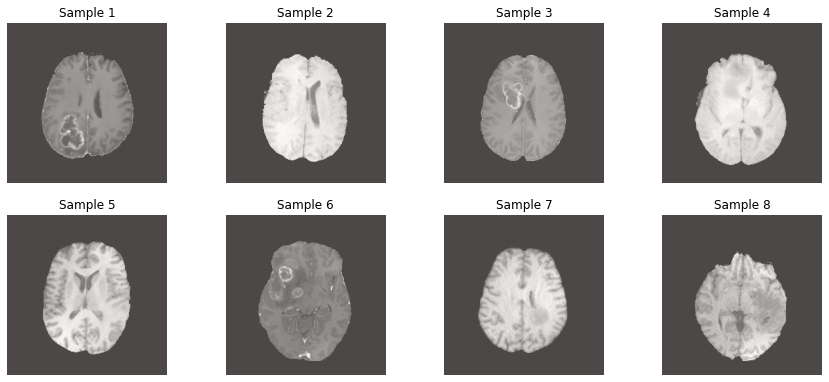

In [31]:
plt.figure(figsize=(15,10))


plt.subplot(341)
plt.title('Sample 1')
plt.axis('off')
plt.imshow(np.squeeze(TR[250,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[250,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(342)
plt.title('Sample 2')
plt.axis('off')
plt.imshow(np.squeeze(TR[550,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[550,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(343)
plt.title('Sample 3')
plt.axis('off')
plt.imshow(np.squeeze(TR[400,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[400,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(344)
plt.title('Sample 4')
plt.axis('off')
plt.imshow(np.squeeze(TR[690,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[690,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(345)
plt.title('Sample 5')
plt.axis('off')
plt.imshow(np.squeeze(TR[850,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[850,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(346)
plt.title('Sample 6')
plt.axis('off')
plt.imshow(np.squeeze(TR[1450,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[1450,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(347)
plt.title('Sample 7')
plt.axis('off')
plt.imshow(np.squeeze(TR[1800,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[1800,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(348)
plt.title('Sample 8')
plt.axis('off')
plt.imshow(np.squeeze(TR[60,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[60,:,:]),alpha=0.3,cmap='Reds')

In [32]:
import pandas as pd
hist_df = pd.DataFrame(history.history)
hist_df['epoch_id'] = [i for i in range (1,len(hist_df)+1)]
hist_df=hist_df.reindex(columns= ['epoch_id', 'loss', 'accuracy','val_loss','val_accuracy'])
print(hist_df)


    epoch_id      loss  accuracy  val_loss  val_accuracy
0          1  0.434894  0.983397  0.367456      0.989264
1          2  0.401340  0.988627  0.367456      0.989264
2          3  0.401340  0.988627  0.367456      0.989264
3          4  0.401340  0.988627  0.367456      0.989264
4          5  0.401340  0.988627  0.367456      0.989264
5          6  0.401340  0.988627  0.367456      0.989264
6          7  0.401340  0.988627  0.367456      0.989264
7          8  0.401340  0.988627  0.367456      0.989264
8          9  0.401340  0.988627  0.367456      0.989264
9         10  0.401340  0.988627  0.367456      0.989264
10        11  0.401340  0.988627  0.367456      0.989264
11        12  0.401340  0.988627  0.367456      0.989264
12        13  0.401340  0.988627  0.367456      0.989264
13        14  0.401340  0.988627  0.367456      0.989264
14        15  0.401340  0.988627  0.367456      0.989264
15        16  0.401340  0.988627  0.367456      0.989264
16        17  0.401340  0.98862

**Unet**

In [33]:
def Convolution(input_tensor,filters):
    
    x = Conv2D(filters=filters,kernel_size=(3, 3),padding = 'same',strides=(1, 1))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 
    return x

def model(input_shape):
    
    inputs = Input((input_shape))
    
    conv_1 = Convolution(inputs,32)
    maxp_1 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_1)
    
    conv_2 = Convolution(maxp_1,64)
    maxp_2 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_2)
    
    conv_3 = Convolution(maxp_2,128)
    maxp_3 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_3)
    
    conv_4 = Convolution(maxp_3,256)
    maxp_4 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_4)
    
    conv_5 = Convolution(maxp_4,512)
    upsample_6 = UpSampling2D((2, 2)) (conv_5)
    
    conv_6 = Convolution(upsample_6,256)
    upsample_7 = UpSampling2D((2, 2)) (conv_6)
    
    upsample_7 = concatenate([upsample_7, conv_3])
    
    conv_7 = Convolution(upsample_7,128)
    upsample_8 = UpSampling2D((2, 2)) (conv_7)
    
    conv_8 = Convolution(upsample_8,64)
    upsample_9 = UpSampling2D((2, 2)) (conv_8)
    
    upsample_9 = concatenate([upsample_9, conv_1])
    
    conv_9 = Convolution(upsample_9,32)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv_9)
    
    model = Model(inputs=[inputs], outputs=[outputs]) 
    
    return model

In [34]:
# Loding the Light weighted CNN
model2 = model(input_shape = (240,240,1))
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 240, 240, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 240, 240, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 240, 240, 32) 128         conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 240, 240, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [35]:
# Compiling the model 
Adam=optimizers.Adam(lr=0.001)
model2.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['accuracy',dice_coef,precision,sensitivity,specificity])

In [36]:
# Fitting the model over the data
import time
start_time = time.time()
history = model2.fit(X_train,Y_train,batch_size=32,epochs=40,validation_split=0.20,verbose=1,initial_epoch=0)
end_time = time.time()
print(end_time - start_time)

Epoch 1/40
66/66 [==============================] - 18s 234ms/step - loss: 0.3800 - accuracy: 0.9172 - dice_coef: 0.0688 - precision: 31.4120 - sensitivity: 0.7339 - specificity: 0.9272 - val_loss: 0.2599 - val_accuracy: 0.9818 - val_dice_coef: 0.0700 - val_precision: 0.7182 - val_sensitivity: 0.6155 - val_specificity: 0.9921
Epoch 2/40
66/66 [==============================] - 13s 203ms/step - loss: 0.1284 - accuracy: 0.9846 - dice_coef: 0.1293 - precision: 665918051.8620 - sensitivity: 0.5980 - specificity: 0.9951 - val_loss: 0.1628 - val_accuracy: 0.9532 - val_dice_coef: 0.1422 - val_precision: 0.2049 - val_sensitivity: 0.8306 - val_specificity: 0.9623
Epoch 3/40
66/66 [==============================] - 13s 203ms/step - loss: 0.0899 - accuracy: 0.9821 - dice_coef: 0.1900 - precision: 9.9563 - sensitivity: 0.6534 - specificity: 0.9919 - val_loss: 0.0805 - val_accuracy: 0.9852 - val_dice_coef: 0.1993 - val_precision: 1561176448.0000 - val_sensitivity: 0.5117 - val_specificity: 0.9952
E

In [37]:
# Evaluating the model on the training and testing data 
model2.evaluate(x=X_train, y=Y_train, batch_size=32 , verbose=1, sample_weight=None, steps=None)
model2.evaluate(x=X_test, y=Y_test, batch_size=32, verbose=1, sample_weight=None, steps=None)

15/15 [==============================] - 1s 85ms/step - loss: -0.1741 - accuracy: 0.9907 - dice_coef: 1.2951 - precision: 0.8907 - sensitivity: 0.9649 - specificity: 0.9988


[-0.1741192489862442,
 0.9907214641571045,
 1.295053482055664,
 0.8907220959663391,
 0.9648919701576233,
 0.9987663626670837]

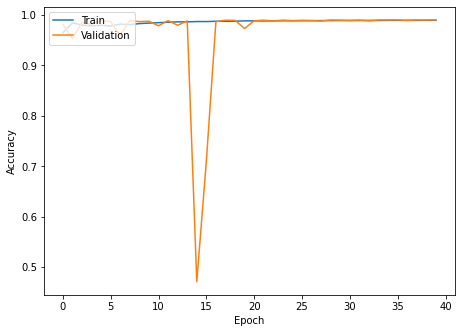

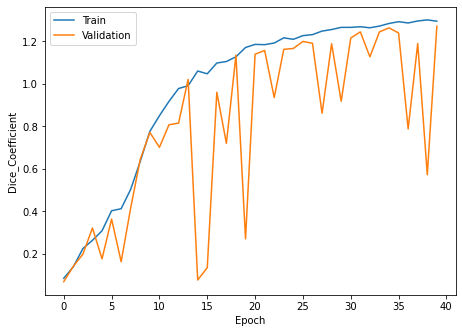

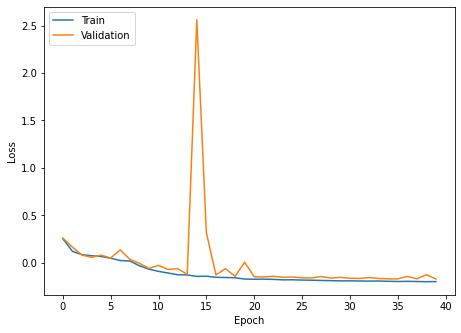

In [38]:
# Plotting the Graphs of Accuracy, Dice_coefficient, Loss at each epoch on Training and Testing data
Accuracy_Graph(history)
Dice_coefficient_Graph(history)
Loss_Graph(history)

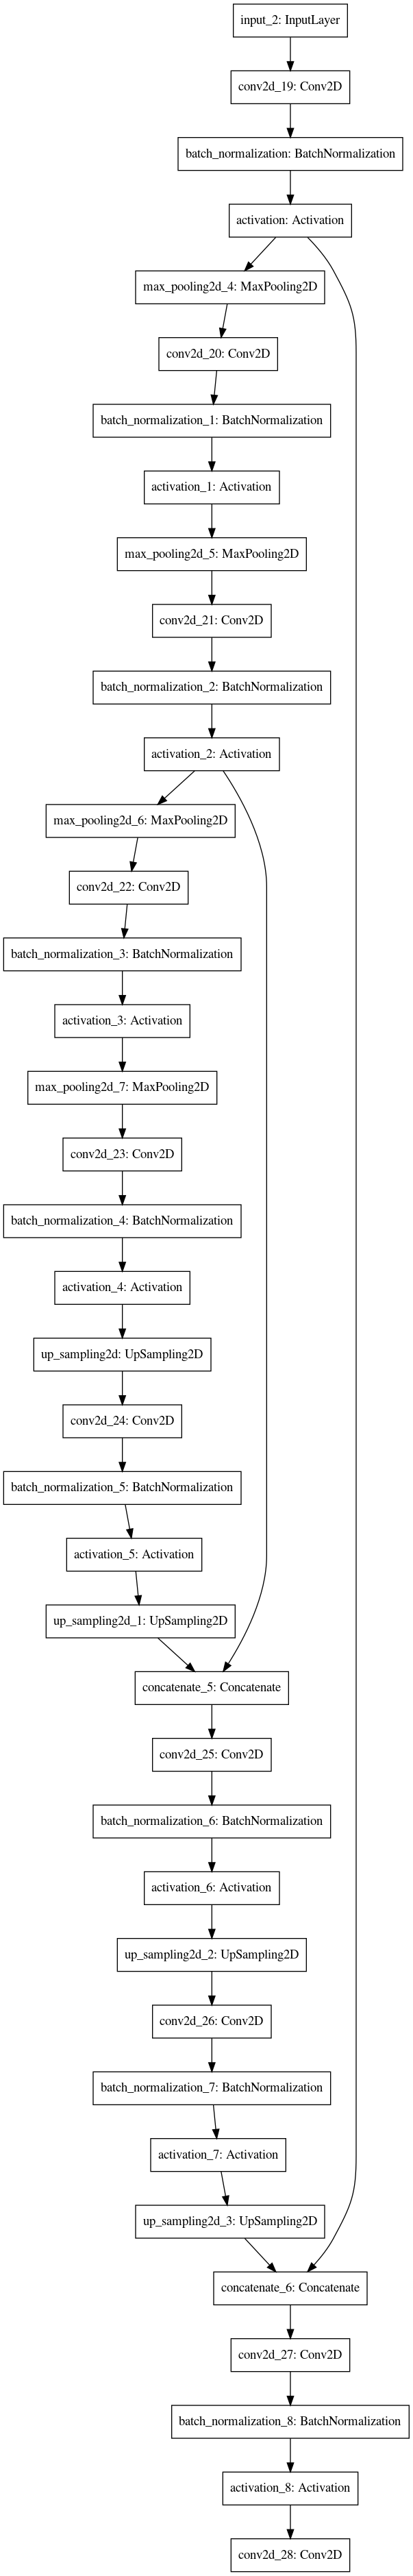

In [39]:
from keras.utils import plot_model
plot_model(model2,to_file='model.png')

In [40]:
model2.save('./BraTs2020.h5')
model2.save_weights('BraTs2020.hdf5')

In [41]:
model2.load_weights('./BraTs2020.h5')

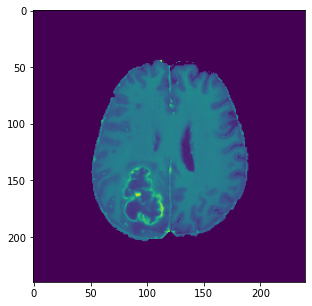

In [42]:
fig = plt.figure(figsize=(5,5))
immmg = TR[250,:,:]
imgplot = plt.imshow(immmg)
plt.show()

In [43]:
pref_Tumor = model2.predict(TR)

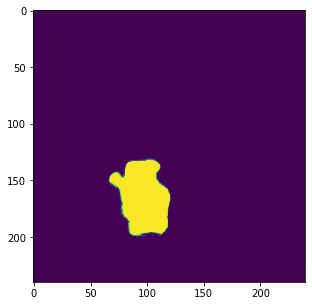

In [44]:
fig = plt.figure(figsize=(5,5))
immmg = pref_Tumor[250,:,:,0]
imgplot = plt.imshow(immmg)
plt.show()

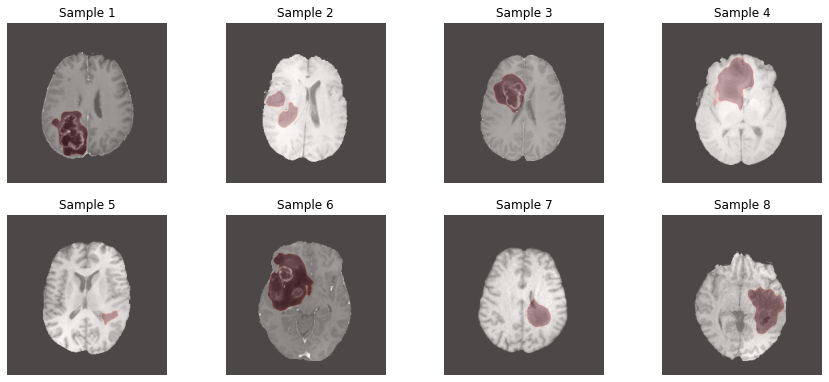

In [45]:
plt.figure(figsize=(15,10))


plt.subplot(341)
plt.title('Sample 1')
plt.axis('off')
plt.imshow(np.squeeze(TR[250,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[250,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(342)
plt.title('Sample 2')
plt.axis('off')
plt.imshow(np.squeeze(TR[550,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[550,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(343)
plt.title('Sample 3')
plt.axis('off')
plt.imshow(np.squeeze(TR[400,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[400,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(344)
plt.title('Sample 4')
plt.axis('off')
plt.imshow(np.squeeze(TR[690,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[690,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(345)
plt.title('Sample 5')
plt.axis('off')
plt.imshow(np.squeeze(TR[850,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[850,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(346)
plt.title('Sample 6')
plt.axis('off')
plt.imshow(np.squeeze(TR[1450,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[1450,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(347)
plt.title('Sample 7')
plt.axis('off')
plt.imshow(np.squeeze(TR[1800,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[1800,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(348)
plt.title('Sample 8')
plt.axis('off')
plt.imshow(np.squeeze(TR[60,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[60,:,:]),alpha=0.3,cmap='Reds')

In [46]:
import pandas as pd
hist_df = pd.DataFrame(history.history)
hist_df['epoch_id'] = [i for i in range (1,len(hist_df)+1)]
hist_df=hist_df.reindex(columns= ['epoch_id', 'loss', 'accuracy','val_loss','val_accuracy'])
print(hist_df)

    epoch_id      loss  accuracy  val_loss  val_accuracy
0          1  0.252936  0.964862  0.259861      0.981778
1          2  0.119758  0.984338  0.162790      0.953249
2          3  0.084381  0.980044  0.080532      0.985171
3          4  0.073278  0.978385  0.056582      0.981607
4          5  0.064895  0.979671  0.078909      0.989003
5          6  0.047512  0.978120  0.049130      0.986795
6          7  0.022296  0.982009  0.135466      0.959536
7          8  0.018532  0.980870  0.035227      0.989005
8          9 -0.032466  0.983028 -0.006821      0.986872
9         10 -0.068436  0.983937 -0.060708      0.987663
10        11 -0.091383  0.984824 -0.028130      0.978689
11        12 -0.108987  0.985674 -0.071504      0.988937
12        13 -0.127106  0.986467 -0.063565      0.979620
13        14 -0.129239  0.986391 -0.122813      0.988275
14        15 -0.144483  0.987059  2.560369      0.470683
15        16 -0.142376  0.987019  0.317510      0.710096
16        17 -0.154177  0.98761